# Semi-supervised learning with autoencoders

In [81]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

## Data 

We will work with credit card data from [Wordline & ULB](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [2]:
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

In [4]:
X = data.drop(["Time", "Class"], axis=1).values
y = data["Class"].values

In [5]:
y.mean()

0.001727485630620034

We will do just very basic preprocessing:

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [64]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((182276, 29), (182276, 1), (45569, 29), (45569, 1), (56962, 29), (56962, 1))

In [47]:
y_train.sum(), y_val.sum(), y_test.sum()

(315, 79, 98)

Before the modeling, we can visualize our data:

In [113]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X_test[:10000])

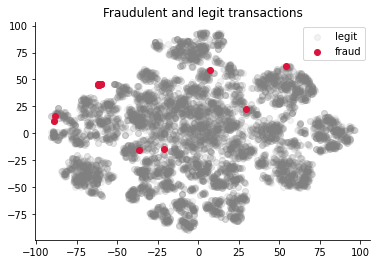

In [128]:
labels = y_test[:10000].reshape(-1)

plt.figure()
plt.scatter(tsne_data[labels == 0, 0], 
            tsne_data[labels == 0, 1], c="grey", alpha=0.1, label="legit")
plt.scatter(tsne_data[labels == 1, 0], 
            tsne_data[labels == 1, 1], c="crimson", alpha=1, label="fraud")
plt.legend()
sns.despine()
plt.title("Fraudulent and legit transactions")
plt.show()

## Baseline MLP classifier

We will train a baseline model to detect fraud.

In [101]:
base_model = keras.Sequential(
    [layers.Dense(29, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")]
)

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()

base_model.compile(optimizer="adam", loss="binary_crossentropy",
                  metrics=[precision, recall, auc]
                  )

base_model.fit(x=X_train, 
               y=y_train,
               epochs=10,
               batch_size=128,
               validation_data=(X_val, y_val)
          )

Epoch 1/10
1425/1425 [==============================] - 8s 6ms/step - loss: 0.0145 - precision_14: 0.8761 - recall_14: 0.3143 - auc_14: 0.8708 - val_loss: 0.0031 - val_precision_14: 0.8250 - val_recall_14: 0.8354 - val_auc_14: 0.9542
Epoch 2/10
1425/1425 [==============================] - 8s 5ms/step - loss: 0.0033 - precision_14: 0.8646 - recall_14: 0.7905 - auc_14: 0.9451 - val_loss: 0.0029 - val_precision_14: 0.8272 - val_recall_14: 0.8481 - val_auc_14: 0.9485
Epoch 3/10
1425/1425 [==============================] - 8s 5ms/step - loss: 0.0029 - precision_14: 0.8676 - recall_14: 0.7905 - auc_14: 0.9516 - val_loss: 0.0027 - val_precision_14: 0.8228 - val_recall_14: 0.8228 - val_auc_14: 0.9552
Epoch 4/10
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0026 - precision_14: 0.8625 - recall_14: 0.7968 - auc_14: 0.9565 - val_loss: 0.0026 - val_precision_14: 0.8272 - val_recall_14: 0.8481 - val_auc_14: 0.9549
Epoch 5/10
1425/1425 [==============================] - 8s 5ms/s

In [107]:
base_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 29)                870       
_________________________________________________________________
dense_58 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_59 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 9         
Total params: 1,495
Trainable params: 1,495
Non-trainable params: 0
_________________________________________________________________


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.74      0.79        98

    accuracy                           1.00     56962
   macro avg       0.92      0.87      0.90     56962
weighted avg       1.00      1.00      1.00     56962



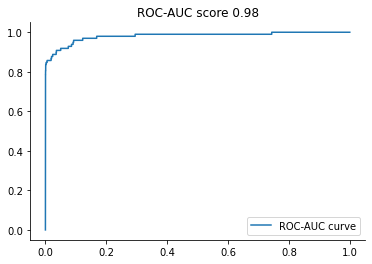

In [102]:
y_pred_prob = base_model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

from sklearn.metrics import classification_report, roc_curve, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocauc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label="ROC-AUC curve")
plt.legend()
plt.title(f"ROC-AUC score {np.round(rocauc, 2)}")
sns.despine()
plt.show()

## Autoencoder pretraining 

In [131]:
encoder = keras.Sequential(
    [layers.Dense(29, activation="relu"),
    layers.Dense(16, activation="relu"),]
)

decoder = keras.Sequential(
    [layers.Dense(29, activation="linear")]
)

ae_model = keras.Sequential(
    [encoder, decoder]
)

In [132]:
ae_model.compile(optimizer="adam", loss=keras.losses.MeanSquaredError(),
                  metrics=["mse"]
                  )

ae_model.fit(x=X_train, 
             y=X_train,
             epochs=10,
             batch_size=128,
             validation_data=(X_val, X_val)
          )

Epoch 1/10
1425/1425 [==============================] - 4s 3ms/step - loss: 0.5891 - mse: 0.5891 - val_loss: 0.4394 - val_mse: 0.4394
Epoch 2/10
1425/1425 [==============================] - 4s 3ms/step - loss: 0.4263 - mse: 0.4263 - val_loss: 0.4232 - val_mse: 0.4232
Epoch 3/10
1425/1425 [==============================] - 5s 4ms/step - loss: 0.4195 - mse: 0.4195 - val_loss: 0.4207 - val_mse: 0.4207
Epoch 4/10
1425/1425 [==============================] - 5s 4ms/step - loss: 0.4186 - mse: 0.4186 - val_loss: 0.4207 - val_mse: 0.4207
Epoch 5/10
1425/1425 [==============================] - 5s 4ms/step - loss: 0.4180 - mse: 0.4180 - val_loss: 0.4238 - val_mse: 0.4238
Epoch 6/10
1425/1425 [==============================] - 5s 4ms/step - loss: 0.4184 - mse: 0.4184 - val_loss: 0.4219 - val_mse: 0.4219
Epoch 7/10
1425/1425 [==============================] - 5s 4ms/step - loss: 0.4174 - mse: 0.4174 - val_loss: 0.4218 - val_mse: 0.4218
Epoch 8/10
1425/1425 [==============================] - 5s 4ms

In [133]:
latent_data = encoder.predict(X_test[:10000])

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(latent_data)

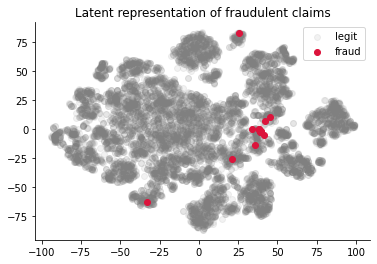

In [134]:
labels = y_test[:10000].reshape(-1)

plt.figure()
plt.scatter(tsne_data[labels == 0, 0], 
            tsne_data[labels == 0, 1], c="grey", alpha=0.1, label="legit")
plt.scatter(tsne_data[labels == 1, 0], 
            tsne_data[labels == 1, 1], c="crimson", alpha=1, label="fraud")
plt.legend()
sns.despine()
plt.title("Latent representation of fraudulent claims")
plt.show()

## Using the pretrained model to boost preformance

In [110]:
# copy encoder
pretrained_encoder = tf.keras.models.clone_model(encoder)

# freeze encoder layers -> we use the latent representations only 
for layer in pretrained_encoder.layers:
    layer.trainable = False

# add the same type of model and match the number of trainable parameters
pretrained_model = keras.Sequential(
    [pretrained_encoder, 
     layers.Dense(32, activation="relu"),
     layers.Dense(16, activation="relu"),
     layers.Dense(8, activation="relu"),
     layers.Dense(1, activation="sigmoid")]
)

pretrained_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   loss="binary_crossentropy",
                   metrics=[precision, recall, auc]
                  )

pretrained_model.fit(x=X_train, 
                     y=y_train,
                     epochs=10,
                     batch_size=128,
                     validation_data=(X_val, y_val)
          )

Epoch 1/10
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0766 - precision_14: 0.0317 - recall_14: 0.2386 - auc_14: 0.6939 - val_loss: 0.0049 - val_precision_14: 0.8095 - val_recall_14: 0.6456 - val_auc_14: 0.9091
Epoch 2/10
1425/1425 [==============================] - 5s 4ms/step - loss: 0.0053 - precision_14: 0.8718 - recall_14: 0.5397 - auc_14: 0.8997 - val_loss: 0.0044 - val_precision_14: 0.8387 - val_recall_14: 0.6582 - val_auc_14: 0.9228
Epoch 3/10
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0049 - precision_14: 0.8517 - recall_14: 0.5651 - auc_14: 0.8984 - val_loss: 0.0053 - val_precision_14: 0.7632 - val_recall_14: 0.7342 - val_auc_14: 0.9268
Epoch 4/10
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0047 - precision_14: 0.8832 - recall_14: 0.6000 - auc_14: 0.8982 - val_loss: 0.0044 - val_precision_14: 0.8182 - val_recall_14: 0.6835 - val_auc_14: 0.9287
Epoch 5/10
1425/1425 [==============================] - 8s 5ms/s

In [111]:
pretrained_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 8)                 1486      
_________________________________________________________________
dense_66 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_67 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_68 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 9         
Total params: 2,447
Trainable params: 961
Non-trainable params: 1,486
_________________________________________________________________


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.60      0.69        98

    accuracy                           1.00     56962
   macro avg       0.91      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



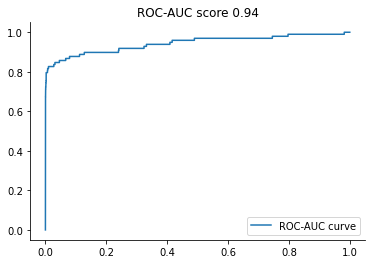

In [112]:
y_pred_prob = pretrained_model.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

cr = classification_report(y_test, y_pred)
print(cr)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
rocauc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label="ROC-AUC curve")
plt.legend()
plt.title(f"ROC-AUC score {np.round(rocauc, 2)}")
sns.despine()
plt.show()

## Setup with insufficient labeled data

In [2]:
from sklearn.model_selection import train_test_split

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [9]:
# data spec
labeled_size = 1000
unlabeled_size = 10_000 
test_sample_size = 10_000

x_labeled = x_train[:labeled_size]
y_labeled = y_train[:labeled_size]

x_unlabeled = x_train[labeled_size:labeled_size+unlabeled_size]

x_test_sample = x_test[:test_sample_size]
y_test_sample = y_test[:test_sample_size]

x_labeled = np.expand_dims(x_labeled, -1).astype("float32") / 255
x_unlabeled = np.expand_dims(x_unlabeled, -1).astype("float32") / 255
x_test_sample = np.expand_dims(x_test_sample, -1).astype("float32") / 255

## Model construction 

In [10]:
latent_dim = 16

encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z = layers.Dense(latent_dim, activation="relu")(x)

encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [12]:
ae_model = keras.Sequential()
ae_model.add(encoder)
ae_model.add(decoder)

In [13]:
ae_model

In [14]:
ae_model.compile(loss="mean_squared_error", 
                 optimizer="adam", 
                 metrics=["mean_squared_error"])

In [15]:
all_train = np.concatenate([x_labeled, x_unlabeled])

ae_model.fit(all_train, all_train,
             batch_size=128,
             epochs = 10)

Epoch 1/10
86/86 [==============================] - 30s 354ms/step - loss: 0.1051 - mean_squared_error: 0.1051
Epoch 2/10
86/86 [==============================] - 32s 375ms/step - loss: 0.0520 - mean_squared_error: 0.0520
Epoch 3/10
86/86 [==============================] - 30s 355ms/step - loss: 0.0276 - mean_squared_error: 0.0276
Epoch 4/10
86/86 [==============================] - 35s 406ms/step - loss: 0.0208 - mean_squared_error: 0.0208
Epoch 5/10
86/86 [==============================] - 33s 381ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 6/10
86/86 [==============================] - 29s 341ms/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 7/10
86/86 [==============================] - 26s 302ms/step - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 8/10
86/86 [==============================] - 24s 283ms/step - loss: 0.0150 - mean_squared_error: 0.0150
Epoch 9/10
86/86 [==============================] - 25s 287ms/step - loss: 0.0144 - mean_squared_error: 0.0144
E

## Freeze the embedding and supervised train

In [18]:
for layer in encoder.layers:
    layer.trainable = False

In [19]:
classifier = keras.Sequential(
    [encoder,
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(10, activation="softmax")]
)

In [20]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                170       
Total params: 69,722
Trainable params: 714
Non-trainable params: 69,008
_________________________________________________________________


In [21]:
classifier.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])

classifier.fit(x_labeled, y_labeled, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
32/32 [==============================] - 0s 7ms/step - loss: 3.7001 - accuracy: 0.1590
Epoch 2/30
32/32 [==============================] - 0s 7ms/step - loss: 2.5707 - accuracy: 0.2170
Epoch 3/30
32/32 [==============================] - 0s 8ms/step - loss: 2.1503 - accuracy: 0.2640
Epoch 4/30
32/32 [==============================] - 0s 7ms/step - loss: 1.9163 - accuracy: 0.3260
Epoch 5/30
32/32 [==============================] - 0s 7ms/step - loss: 1.7331 - accuracy: 0.3980
Epoch 6/30
32/32 [==============================] - 0s 7ms/step - loss: 1.5747 - accuracy: 0.4810
Epoch 7/30
32/32 [==============================] - 0s 9ms/step - loss: 1.4386 - accuracy: 0.5390
Epoch 8/30
32/32 [==============================] - 0s 9ms/step - loss: 1.3075 - accuracy: 0.5870
Epoch 9/30
32/32 [==============================] - 0s 9ms/step - loss: 1.1912 - accuracy: 0.6380
Epoch 10/30
32/32 [==============================] - 0s 8ms/step - loss: 1.0864 - accuracy: 0.6700
Epoch 11/30
32/32 [

In [22]:
y_pred = classifier.predict(x_test_sample)

In [23]:
y_pred.shape

(10000, 10)

In [24]:
from sklearn.metrics import classification_report

report = classification_report(y_test_sample, np.argmax(y_pred, axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       980
           1       0.93      0.97      0.95      1135
           2       0.81      0.88      0.85      1032
           3       0.82      0.74      0.78      1010
           4       0.85      0.75      0.80       982
           5       0.73      0.73      0.73       892
           6       0.90      0.87      0.88       958
           7       0.86      0.84      0.85      1028
           8       0.84      0.75      0.79       974
           9       0.70      0.84      0.76      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



## Comparison with only supervised training 

In [25]:
encoder_inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z = layers.Dense(latent_dim, activation="relu")(x)

encoder = keras.Model(encoder_inputs, z, name="encoder")

base_classifier = keras.Sequential(
    [encoder,
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(10, activation="softmax")]
)

In [26]:
base_classifier.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])

base_classifier.fit(x_labeled, y_labeled, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
32/32 [==============================] - 1s 17ms/step - loss: 2.2036 - accuracy: 0.2060
Epoch 2/30
32/32 [==============================] - 1s 20ms/step - loss: 1.7128 - accuracy: 0.3770
Epoch 3/30
32/32 [==============================] - 1s 17ms/step - loss: 1.1058 - accuracy: 0.6340
Epoch 4/30
32/32 [==============================] - 1s 16ms/step - loss: 0.7696 - accuracy: 0.7310
Epoch 5/30
32/32 [==============================] - 1s 19ms/step - loss: 0.5729 - accuracy: 0.8210
Epoch 6/30
32/32 [==============================] - 0s 15ms/step - loss: 0.4356 - accuracy: 0.8800
Epoch 7/30
32/32 [==============================] - 0s 15ms/step - loss: 0.3331 - accuracy: 0.9090
Epoch 8/30
32/32 [==============================] - 0s 15ms/step - loss: 0.2705 - accuracy: 0.9290
Epoch 9/30
32/32 [==============================] - 1s 20ms/step - loss: 0.2526 - accuracy: 0.9280
Epoch 10/30
32/32 [==============================] - 1s 19ms/step - loss: 0.2211 - accuracy: 0.9450
Epoch 11/

In [27]:
y_pred = base_classifier.predict(x_test_sample)

report = classification_report(y_test_sample, np.argmax(y_pred, axis=1))
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.95      0.97      0.96      1135
           2       0.90      0.87      0.88      1032
           3       0.86      0.83      0.84      1010
           4       0.92      0.90      0.91       982
           5       0.80      0.88      0.84       892
           6       0.94      0.91      0.92       958
           7       0.84      0.90      0.87      1028
           8       0.88      0.78      0.83       974
           9       0.83      0.87      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

